In [33]:
import os
import numpy as np
import cv2
from hmmlearn import hmm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import sys
#sys.stdout.reconfigure(encoding='utf-8')
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt 

In [34]:
# dataset_path = r"D:\4th year\Lip reading\Computer-Vision-Lip-Reading-2.0-main\Computer-Vision-Lip-Reading-2.0-main\collected_data"
dataset_path =  r"D:\4th year\GP FOLDER\REPO\Arabic-Lip-Reading\Dataset"
# output_path = r"D:\4th year\Lip reading\output_preprocessed"  # Path to save preprocessed videos



#words = ["السلام", "عليكم", "ورحمة","الله"]  ## Total vedios 427 147 , 60 , 155 , 65 
target_words = ['السلام','عليكم','الله','اتفاق','البلاد','الجيش']
word_models = {}


In [35]:
# Function to collect video paths for each word
def collect_video_paths():
    word_video_paths = {word: [] for word in target_words}
    #for word in words:
    #word_folder_prefix = word + "_"
    for folder_name in os.listdir(dataset_path):
        if folder_name not in target_words:
            continue
        #if folder_name.startswith(word_folder_prefix):
        #print(folder_name)
        #print(dataset_path)
        word_path = os.path.join(dataset_path, folder_name)
        for video_name in os.listdir(word_path):
            #print(video_name)  # video_name = "00003144_اتفاق(اتفاق)_cropped.mp4"  # example video file name  

            if not (video_name.endswith('.mp4') and 'cropped' in video_name):
                continue

            # Process the file if it meets the conditions
            #print("Processing file:", video_name)
            # Add your processing code here...

            video_path = os.path.join(dataset_path, folder_name, video_name)
            #print(video_path)   
            if os.path.isfile(video_path):
                word_video_paths[folder_name].append(video_path)
    return word_video_paths

# Load dataset and split into training and testing sets
video_paths = collect_video_paths()
train_paths = {}
test_paths = {}

# Split each word's video paths into training and testing sets
for word, paths in video_paths.items():
    train, test = train_test_split(paths, test_size=0.2, random_state=42)
    train_paths[word] = train
    test_paths[word] = test


In [ ]:
import cv2
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
from hmmlearn import hmm

# Feature extractor: Reads video, converts frames to grayscale, resizes, flattens, and normalizes
def extract_features(video_path, save_video=False):
    cap = cv2.VideoCapture(video_path)
    features = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # Resize to (65, 40) and flatten into a 1D array
        resized_frame = cv2.resize(gray_frame, (65, 40)).flatten()
        features.append(resized_frame)
        
    cap.release()
    
    # Scale features for stability: StandardScaler converts the list of feature vectors 
    # into a numpy array, then scales each feature to have zero mean and unit variance.
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(np.array(features))
    return scaled_features

# Dictionary to store trained models (global or passed as needed)
word_models = {}

# Training models for each word
def train_models(train_paths):
    for word, video_paths in train_paths.items():
        sequences = []
        for video_path in video_paths:
            feature_sequence = extract_features(video_path)
            sequences.append(feature_sequence)

        # Train HMM for each word if sequences exist
        if sequences:
            print(f"Training model for word '{word}'")
            # Concatenate features and prepare sequence lengths
            X = np.concatenate(sequences)
            lengths = [len(seq) for seq in sequences]
            
            # Create and train the HMM for the current word
            model = hmm.GaussianHMM(n_components=9, covariance_type="diag", n_iter=50, tol=1e-10)
            model.fit(X, lengths)
            
            # Store the trained model
            word_models[word] = model


# Train models on training set
train_models(train_paths)


Training model for word 'السلام'
Training model for word 'عليكم'
Training model for word 'الله'
Training model for word 'اتفاق'
Training model for word 'البلاد'


Model is not converging.  Current: -10292003.011027128 is not greater than -10292003.011026295. Delta is -8.326023817062378e-07


Training model for word 'الجيش'


Model is not converging.  Current: -9963415.720581733 is not greater than -9963415.720578726. Delta is -3.0063092708587646e-06


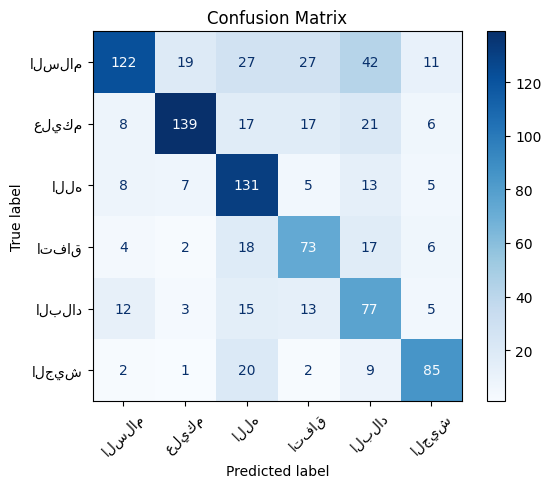

Training Accuracy: 63.40%


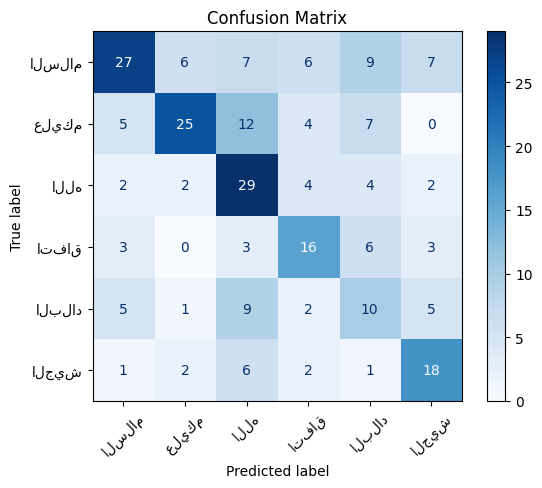

Testing Accuracy: 49.80%


In [37]:

def predict_word(video_path):

    test_sequence = extract_features(video_path, save_video=True)
    
    # Score the test sequence with each trained model
    scores = {}
    for word, model in word_models.items():
        try:
            log_prob = model.score(test_sequence)
            scores[word] = log_prob
        except Exception as e:
            print(f"Error scoring word '{word}': {e}")
            scores[word] = float('-inf')

    # Return the word with the highest score
    predicted_word = max(scores, key=scores.get)
    return predicted_word

# Calculate accuracy for a given set of video paths
def calculate_accuracy(paths):
    correct_predictions = 0
    total_sequences = 0

    for word, video_paths in paths.items():
        for video_path in video_paths:
            # Predict the word
            predicted_word = predict_word(video_path)
            if predicted_word == word:
                correct_predictions += 1
            total_sequences += 1

    accuracy = (correct_predictions / total_sequences) * 100 if total_sequences > 0 else 0
    return accuracy


def evaluate_and_confusion_matrix(paths):
    correct_predictions = 0
    total_sequences = 0
    actual_labels = []
    predicted_labels = []

    for word, video_paths in paths.items():
        for video_path in video_paths:
            # Predict the word
            predicted_word = predict_word(video_path)
            actual_labels.append(word)
            predicted_labels.append(predicted_word)

            # Check if the prediction was correct
            if predicted_word == word:
                correct_predictions += 1
            # else:
            #     # Display misclassified video
            #     print(f"Misclassified video: {video_path}")
            #     print(f"Actual: {word}, Predicted: {predicted_word}")
            #     cap = cv2.VideoCapture(video_path)
            #     while cap.isOpened():
            #         ret, frame = cap.read()
            #         if not ret:
            #             break
            #         cv2.imshow("Misclassified Video", frame)
            #         if cv2.waitKey(20) & 0xFF == ord('q'):  # Press 'q' to close the video early
            #             break
            #     cap.release()
            #     cv2.destroyAllWindows()

            total_sequences += 1

    # Calculate accuracy
    accuracy = (correct_predictions / total_sequences) * 100 if total_sequences > 0 else 0

    # Calculate and display the confusion matrix
    labels = list(paths.keys())  # list of words for confusion matrix labels
    cm = confusion_matrix(actual_labels, predicted_labels, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy


# Evaluate and display confusion matrix for both train and test sets
train_accuracy = evaluate_and_confusion_matrix(train_paths)
print(f"Training Accuracy: {train_accuracy:.2f}%")

test_accuracy = evaluate_and_confusion_matrix(test_paths)
print(f"Testing Accuracy: {test_accuracy:.2f}%")